In [1]:
import os, random, glob, math
import numpy as np
import pandas as pd

from PIL import Image, ImageDraw
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential, Model, load_model
from keras.layers import GlobalAveragePooling2D, Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('tf')
K.set_floatx("float32")

Using TensorFlow backend.


In [2]:
TRAIN_DIR = '../data/train/'
TEST_DIR = '../data/test_stg1/'
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
modelStr = 'Crop'
ROWS = 224
COLS = 224
BatchSize = 64
LearningRate = 1e-4
if not os.path.exists('./checkpoints'):
    os.mkdir('./checkpoints')
le = LabelEncoder()
le.fit(FISH_CLASSES)
le.transform(FISH_CLASSES)


array([0, 1, 2, 3, 4, 5, 6, 7])

In [3]:
#Loading data

import pickle

if os.path.exists('../data/images_annotations_{}_{}.pickle'.format(ROWS, COLS)):
    print ('Exist images_annotations_{}_{}.pickle. Loading data from file.'.format(ROWS, COLS))
    with open('../data/images_annotations_{}_{}.pickle'.format(ROWS, COLS), 'rb') as f:
        images_annotations = pickle.load(f)
    images = images_annotations['images']
    annotations = images_annotations['annotations']
else:
    print ('Loading data from original images. Generating images_annotations_{}_{}.pickle.'.format(ROWS, COLS))
    
    images = []
    annotations = []

    crop_classes=FISH_CLASSES[:]
    crop_classes.remove('NoF')
    crop_classes

    for c in crop_classes:
        labels = pd.read_json('../data/annotation/'+c.lower()+'_labels.json')
        for i in range(len(labels)):
            try:
                img_filename = labels.iloc[i,2]
                print(img_filename)
                l1 = pd.DataFrame((labels[labels.filename==img_filename].annotations).iloc[0])
                im = Image.open(TRAIN_DIR+c+'/'+img_filename)
                im_resized = im.resize((COLS, ROWS), Image.BILINEAR)
                w, h = im.size
                x_ratio = float(COLS)/w
                y_ratio = float(ROWS)/h
                annotations.append([l1.iloc[0,1]*x_ratio,
                                    l1.iloc[0,2]*y_ratio,
                                    l1.iloc[1,1]*x_ratio,
                                    l1.iloc[1,2]*y_ratio])
                images.append(np.asarray(im_resized))
                print('success')
            except:
                print('fail')
    
    images = np.asarray(images, dtype=np.uint8)
    annotations = np.asarray(annotations)
    #save data to file
    images_annotations = {'images': images,'annotations': annotations }

    with open('../data/images_annotations_{}_{}.pickle'.format(ROWS, COLS), 'wb') as f:
        pickle.dump(images_annotations, f)
        
images_train, images_valid, annotations_train, annotations_valid = train_test_split(images, annotations, test_size=0.2, random_state=None)

Exist images_annotations_224_224.pickle. Loading data from file.


In [4]:
#生成图像随机变换矩阵
#modified from code https://github.com/fchollet/keras/blob/master/keras/preprocessing/image.py

def transform_matrix_offset_center(matrix, w, h):
    center_x = float(w) / 2 + 0.5
    center_y = float(h) / 2 + 0.5
    #图像center移到原点，进行rotation和shear
    offset_matrix = np.array([[1, 0, center_x], [0, 1, center_y], [0, 0, 1]])
    #移回来
    reset_matrix = np.array([[1, 0, -center_x], [0, 1, -center_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(reset_matrix, matrix), offset_matrix)
    return transform_matrix

def random_transform_matrix(image,
                            rotation_range=0.,
                            width_shift_range=0.,
                            height_shift_range=0.,
                            shear_range=0.,
                            zoom_range=0.,
                            horizontal_flip=False,
                            vertical_flip=False):
    
    h, w = image.shape[0], image.shape[1]
       
    #图像上下翻转
    hflip_matrix=np.eye(3)
    if horizontal_flip:
        if np.random.random() < 0.5:
            #print("horizontal_flip")
            hflip_matrix = np.array([[-1, 0, w],
                                     [0, 1, 0],
                                     [0, 0, 1]])
    #图像左右翻转                              
    vflip_matrix=np.eye(3)
    if vertical_flip:
        if np.random.random() < 0.5:
            #print("vertical_flip")
            vflip_matrix = np.array([[1, 0, 0],
                                     [0, -1, h],
                                     [0, 0, 1]])
    #图像顺时针旋转theta       
    if rotation_range:
        theta = np.pi / 180 * np.random.uniform(-rotation_range, rotation_range)
    else:
        theta = 0
    #print("theta =",theta)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])
    
    #图像往正轴移动tx，ty
    if height_shift_range:
        ty = np.random.uniform(-height_shift_range, height_shift_range) * h
    else:
        ty = 0

    if width_shift_range:
        tx = np.random.uniform(-width_shift_range, width_shift_range) * w
    else:
        tx = 0
    #print("tx =",tx)
    #print("ty =",ty)
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])
    
    #图像顺时针shear
    if shear_range:
        shear = np.random.uniform(-shear_range, shear_range)
    else:
        shear = 0
    #print("shear =",shear)
    shear_matrix = np.array([[1, -np.sin(shear), 0],
                             [0, np.cos(shear), 0],
                             [0, 0, 1]])
    
    #以center为中心图像放大zx，zy
    if np.isscalar(zoom_range):
        zoom_range = [1 - zoom_range, 1 + zoom_range]
    elif len(zoom_range) == 2:
        zoom_range = [zoom_range[0], zoom_range[1]]
    else:
        raise ValueError('zoom_range should be a float or '
                         'a tuple or list of two floats. '
                         'Received arg: ', zoom_range)
            
    if zoom_range[0] == 1 and zoom_range[1] == 1:
        zx, zy = 1, 1
    else:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
    #print("zx =",zx)
    #print("zy =",zy)
    zoom_matrix = np.array([[zx, 0, (1-zx)*w/2.],
                            [0, zy, (1-zy)*h/2.],
                            [0, 0, 1]])
    #transform_matrix = zoom_matrix
    transform_matrix = np.dot(shear_matrix, rotation_matrix)
    transform_matrix = transform_matrix_offset_center(transform_matrix, w, h)
    transform_matrix = np.dot(np.dot(np.dot(np.dot(translation_matrix, 
                                                   zoom_matrix), 
                                            transform_matrix), 
                                     vflip_matrix), 
                              hflip_matrix)
    return transform_matrix[:2,:]

In [5]:
train_losses = []
valid_losses = []
val_nb_batch = 50


def model_train(model, images_train, annotations_train, images_valid, annotations_valid, nb_batch = 1000):
    import queue
    q_images = queue.Queue()
    q_annotations = queue.Queue()
    
    min_val_loss = float("Inf")
    for i in range(nb_batch):
        count = 0
        x_batch = np.ndarray((BatchSize, ROWS, COLS, 3), dtype=np.float32)
        y_batch = np.ndarray((BatchSize, 4), dtype=np.float32)
        
        while count<BatchSize:
            if q_images.empty():

                #shuffle epoch
                epoch_size = len(images_train)
                index = np.random.permutation(epoch_size)
                images_train = images_train[index,:,:,:]
                annotations_train = annotations_train[index,:]

                for i in range(epoch_size):
                    q_images.put(images_train[i])
                    q_annotations.put(annotations_train[i])
            else:
                image = q_images.get()
                annotation = q_annotations.get()
                rescale = 1./255,
                image = image*rescale
                M = random_transform_matrix(image,
                                            rotation_range=20,
                                            shear_range=0.2,
                                            zoom_range=0.1,
                                            width_shift_range=0.1,
                                            height_shift_range=0.1,
                                            horizontal_flip=True,
                                            vertical_flip=True)
                h, w = image.shape[0], image.shape[1]
                image_transformed = cv2.warpAffine(image, M, (w, h), borderMode=0)
                head_transformed = np.dot(M,np.array([annotation[0],annotation[1],1]))
                tail_transformed = np.dot(M,np.array([annotation[2],annotation[3],1]))
                if 0<=head_transformed[0]<=w and 0<=head_transformed[1]<=h and \
                0<=tail_transformed[0]<=w and 0<=tail_transformed[1]<=h:
                    x_batch[count] = image_transformed
                    y_batch[count] = [head_transformed[0],head_transformed[1],tail_transformed[0],tail_transformed[1]]
                    count += 1
       
        train_losses.append(model.train_on_batch(x_batch, y_batch))
        if i % val_nb_batch == 0:
            print('Batch ', i)
            valid_losses.append(model.evaluate(images_valid, annotations_valid, batch_size=BatchSize, verbose=1))  
            print('batch_loss', train_losses[-1], 'valid_loss', valid_losses[-1])
            if valid_losses[-1] < min_val_loss:
                min_val_loss = valid_losses[-1]
                model.save('./checkpoints/model-{0}-{1:.1f}-{2:.1f}.h5'.format(i,train_losses[-1],valid_losses[-1]))
                print('Saving model-{0}-{1:.1f}-{2:.1f}.h5'.format(i,train_losses[-1],valid_losses[-1]))

In [6]:
#VGG16
#stg1 training

from keras.applications.vgg16 import VGG16

optimizer = Adam(lr=LearningRate)

base_model = VGG16(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Dense(256, init='glorot_normal', activation='relu')(x)
#x = LeakyReLU(alpha=0.33)(x)
#x = Dropout(0.5)(x)
#x = Dense(256, init='glorot_normal', activation='relu')(x)
#x = LeakyReLU(alpha=0.33)(x)
#x = Dropout(0.5)(x)
predictions = Dense(4, init='glorot_normal')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# train the model on the new data for a few epochs
model_train(model, images_train, annotations_train, images_valid, annotations_valid, nb_batch=1001)

Batch  50
660/660 [==============================] - 20s    
batch_loss 14493.0 valid_loss 12935.2986032
Saving model-50-14493.0-12935.3.h5
Batch  100
660/660 [==============================] - 9s     
batch_loss 15008.3 valid_loss 11606.9902225
Saving model-100-15008.3-11607.0.h5
Batch  150
660/660 [==============================] - 9s     
batch_loss 14142.3 valid_loss 10361.5814986
Saving model-150-14142.3-10361.6.h5
Batch  200
660/660 [==============================] - 9s     
batch_loss 14784.1 valid_loss 9208.49042377
Saving model-200-14784.1-9208.5.h5
Batch  250
660/660 [==============================] - 9s     
batch_loss 14161.2 valid_loss 8146.74591915
Saving model-250-14161.2-8146.7.h5
Batch  300
660/660 [==============================] - 9s     
batch_loss 13929.7 valid_loss 7170.79269058
Saving model-300-13929.7-7170.8.h5
Batch  350
660/660 [==============================] - 9s     
batch_loss 14011.8 valid_loss 6279.34266986
Saving model-350-14011.8-6279.3.h5
Batch  400
6

In [ ]:
#VGG16
#stg2 training

files = glob.glob('./checkpoints/*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file ' + files[index])
model = load_model(files[index])

from keras.applications.vgg16 import VGG16

optimizer = Adam(lr=LearningRate)

base_model = VGG16(weights='imagenet', include_top=False)
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:14]:
   layer.trainable = False
for layer in model.layers[14:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=optimizer, loss='mean_squared_error')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers

model_train(model, images_train, annotations_train, images_valid, annotations_valid, nb_batch=1001)

In [ ]:
#Resnet50
#stg1 training

from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
#x = Dense(256, init='glorot_normal', activation='relu')(x)
#x = LeakyReLU(alpha=0.33)(x)
#x = Dropout(0.5)(x)
#x = Dense(256, init='glorot_normal', activation='relu')(x)
#x = LeakyReLU(alpha=0.33)(x)
#x = Dropout(0.5)(x)
predictions = Dense(4, init='glorot_normal')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = Adam(lr=LearningRate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# train the model on the new data for a few epochs
model_train(model, images_train, annotations_train, images_valid, annotations_valid, nb_batch=1001)

In [ ]:
#Resnet50
#stg2 training

print('Loading model from checkpoints file model-300-10015.0-5486.2.h5')
model = load_model('./checkpoints/model-300-10015.0-5486.2.h5')

from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:164]:
   layer.trainable = False
for layer in model.layers[164:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
optimizer = Adam(lr=LearningRate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers

model_train(model, images_train, annotations_train, images_valid, annotations_valid, nb_batch=1001)

In [ ]:
#reduce learning rate

#files = glob.glob('./checkpoints/*')
#val_losses = [float(f.split('-')[-1][:-5]) for f in files]
#index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file model-300-10015.0-5486.2.h5')
model = load_model('./checkpoints/model-300-10015.0-5486.2.h5')

optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model_train(model, images_train, annotations_train, images_valid, annotations_valid, nb_batch=1001)

In [ ]:
#resume training

files = glob.glob('./checkpoints/*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file ' + files[index])
model = load_model(files[index])

model_train(model, images_train, annotations_train, images_valid, annotations_valid, nb_batch=1001)

In [ ]:
plt.plot(train_losses); plt.plot([val_nb_batch*i for i in range(len(valid_losses))], valid_losses); 
plt.title('model loss'); plt.ylabel('mse'); plt.xlabel('batch');
plt.legend(['train', 'valid'], loc='upper left');
plt.show()

In [53]:
#visualize aligner

print('Loading model from checkpoints file model-350-8477.0-2203.5.h5')
model = load_model('./checkpoints/model-350-8477.0-2203.5.h5')

predicts = model.predict(images_train, batch_size=32, verbose=1)

Loading model from checkpoints file model-350-8477.0-2203.5.h5


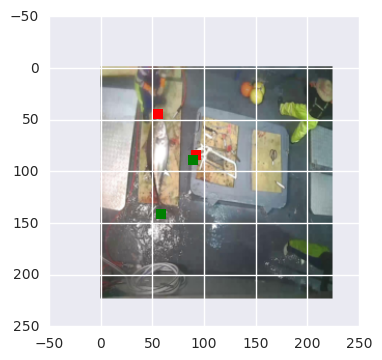

In [63]:
i = 7
image = images_train[i]
annotation = annotations_train[i]
predict = predicts[i]

plt.imshow(image)
plt.plot(annotation[0], annotation[1],'rs')
plt.plot(annotation[2], annotation[3],'gs')
plt.plot(predict[0], predict[1],'rs')
plt.plot(predict[2], predict[3],'gs')


In [ ]:
###clear checkpoints folder

if not os.path.exists('./checkpoints'):
    os.mkdir('./checkpoints')
files = glob.glob('./checkpoints/*')
for f in files:
    os.remove(f)

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc']); plt.plot(hist.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()